In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building and Training Transformer

In [2]:

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")

print(f'device count: {torch.cuda.device_count()}')
print(f'current device: {torch.cuda.current_device()}')
current_device = torch.cuda.current_device()
print(f'device name: {torch.cuda.get_device_name(current_device)}')

CUDA is available!
device count: 1
current device: 0
device name: NVIDIA GeForce RTX 2070 SUPER


In [3]:
class StandardScaler:
    def __init__(self, mean=None, std=None, epsilon=1e-7):
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, sequence_length, transformer_input_dim, num_heads, num_classes, num_layers=6, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, input_dim))
        self.mlp = nn.Linear(input_dim, transformer_input_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=transformer_input_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.classifier = nn.Linear(transformer_input_dim, num_classes)
        self.position_embeddings = nn.Embedding(sequence_length + 1, transformer_input_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, src):
        batch_size = src.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        src = torch.cat((cls_tokens, src), dim=1)

        positions = torch.arange(src.shape[1], device=src.device).expand(batch_size, src.shape[1])
        src = self.mlp(src) + self.position_embeddings(positions)

        output = self.transformer_encoder(src)
        cls_token_output = output[:, 0, :]
        logits = self.classifier(cls_token_output)
        return self.softmax(logits)

    def to(self, device):
        super(TransformerClassifier, self).to(device)
        self.cls_token = self.cls_token.to(device)
        self.position_embeddings = self.position_embeddings.to(device)
        return self

In [4]:
class AudioFeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.features[idx]
        label = self.labels[idx]
        return sample, label

In [120]:
data = np.load("X-y.npz") # X is 3 dimensional (batch, sequence-length, sequence-dim), y is bucketed RIFL value
X = data['X']
y = data['y']
X = torch.Tensor(X).to(device)
y = torch.Tensor(y).type(torch.long).to(device)

batch_size = 64
num_epochs = 300
transformer_input_dim=512
dropout = 0.0
learning_rate = 0.00001
num_attention_heads = 4
num_transformer_layers = 4
num_classes=3
sequence_length = X.shape[1]

# train validation split
scaler = StandardScaler()
X = scaler.fit_transform(X)
dataset = AudioFeatureDataset(X, y)
val_size = int(len(dataset) * 0.2)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate model
model = TransformerClassifier(input_dim=X.shape[2], num_heads=num_attention_heads, sequence_length=sequence_length, num_layers=num_transformer_layers, num_classes=num_classes, transformer_input_dim=transformer_input_dim, dropout=dropout)
model.to(device)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y.cpu().numpy()), y=y.cpu().numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10, threshold=1e-2)

In [121]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.long()
        # print("outputs: ", outputs)
        # print("labels: ", labels)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = torch.argmax(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_preds / total_preds
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total_preds = 0
    
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.long()
            loss = loss_function(outputs, labels)
            
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct_preds += (predicted == labels).sum().item()
            val_total_preds += labels.size(0)

    val_epoch_loss = val_running_loss / len(val_dataloader)
    val_epoch_accuracy = val_correct_preds / val_total_preds
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.4f}")
    # scheduler.step()
    print(f'current learning rate: {optimizer.param_groups[0]["lr"]}\n')


Epoch 1, Loss: 1.1029, Accuracy: 0.1133, Val Loss: 1.1051, Val Accuracy: 0.3000
current learning rate: 1e-05

Epoch 2, Loss: 1.0843, Accuracy: 0.3892, Val Loss: 1.1145, Val Accuracy: 0.3400
current learning rate: 1e-05

Epoch 3, Loss: 1.1139, Accuracy: 0.3103, Val Loss: 1.1220, Val Accuracy: 0.2600
current learning rate: 1e-05

Epoch 4, Loss: 1.0619, Accuracy: 0.2660, Val Loss: 1.1192, Val Accuracy: 0.2600
current learning rate: 1e-05

Epoch 5, Loss: 1.0775, Accuracy: 0.3054, Val Loss: 1.1153, Val Accuracy: 0.3600
current learning rate: 1e-05

Epoch 6, Loss: 1.0648, Accuracy: 0.4286, Val Loss: 1.1131, Val Accuracy: 0.4000
current learning rate: 1e-05

Epoch 7, Loss: 1.0322, Accuracy: 0.3941, Val Loss: 1.1158, Val Accuracy: 0.2800
current learning rate: 1e-05

Epoch 8, Loss: 1.0636, Accuracy: 0.3596, Val Loss: 1.1183, Val Accuracy: 0.3800
current learning rate: 1e-05

Epoch 9, Loss: 1.0643, Accuracy: 0.4680, Val Loss: 1.1203, Val Accuracy: 0.4200
current learning rate: 1e-05

Epoch 10, 

KeyboardInterrupt: 

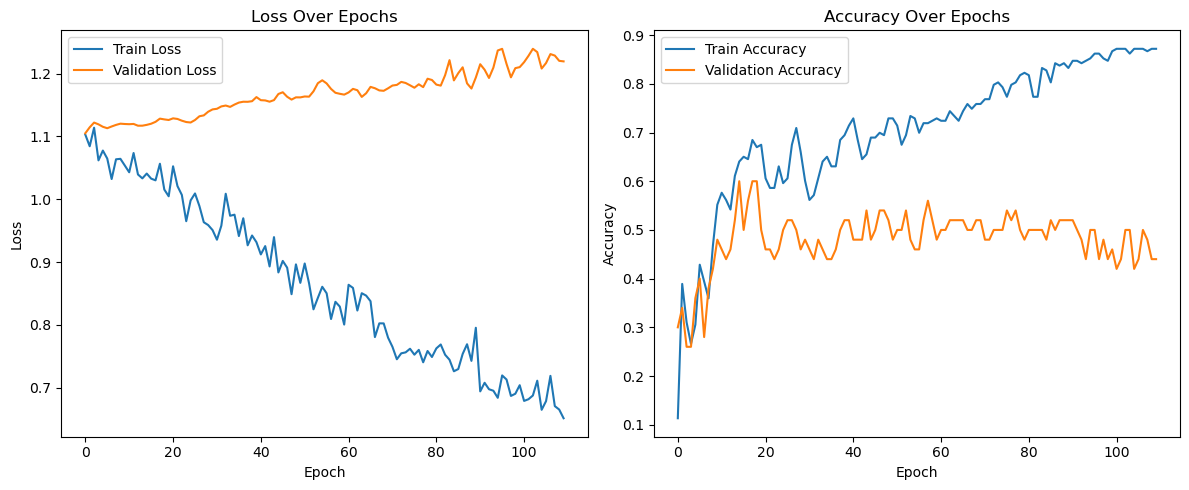

In [122]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(train_losses)), train_accuracies, label='Train Accuracy')
plt.plot(range(len(val_losses)), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

tensor([2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 1, 1,
        1, 1, 0, 1, 1, 2, 1, 2, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 1, 1, 1, 2, 1,
        1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2,
        1, 1, 2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 2, 1], device='cuda:0')
tensor([0, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 0, 1, 1, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 0, 2, 1], device='cuda:0')
tensor([1, 1, 2, 2, 2, 1, 1, 0, 0, 1, 0], device='cuda:0')
Confusion matrix, without normalization


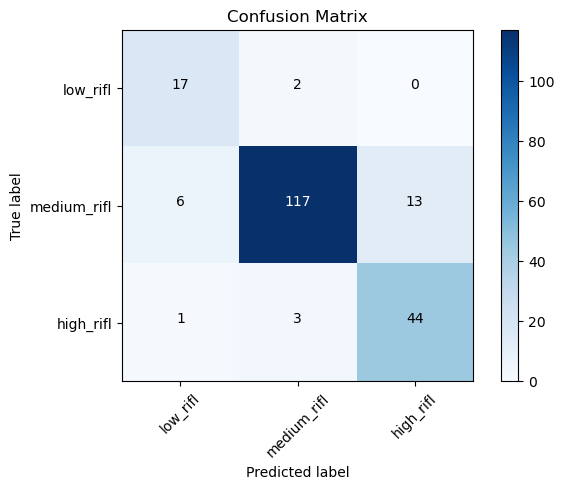

In [123]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No need to track gradients for this
with torch.no_grad():
    for inputs, labels in train_dataloader:
        print(labels)
        # Assuming the model outputs logits, get the maximum index as the predicted label
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions and true labels
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

class_names = ['low_rifl', 'medium_rifl', 'high_rifl']
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
plt.show()

tensor([1, 1, 0, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1,
        1, 2], device='cuda:0')
Confusion matrix, without normalization


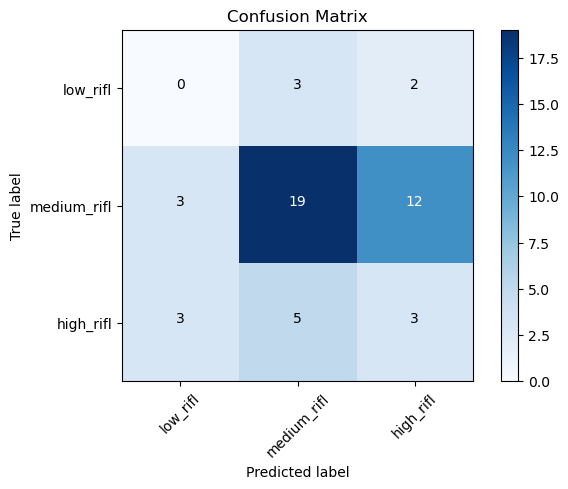

In [124]:
model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# No need to track gradients for this
with torch.no_grad():
    for inputs, labels in val_dataloader:
        print(labels)
        # Assuming the model outputs logits, get the maximum index as the predicted label
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Store predictions and true labels
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

class_names = ['low_rifl', 'medium_rifl', 'high_rifl']
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
plt.show()